In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib.image as mpimg
from drawarrow import fig_arrow, ax_arrow
from pyfonts import load_font, load_google_font
from highlight_text import fig_text, ax_text

import warnings
warnings.filterwarnings("ignore")

In [2]:
flint_mdeq = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-11-04/flint_mdeq.csv")
flint_vt = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-11-04/flint_vt.csv")

In [3]:
flint_mdeq.head(2)

,sample,lead,lead2,notes
0,1,0,0.0,NaN
1,2,104,NaN,sample removed: house had a filter


In [4]:
# Select a column, add a new column and reorder the columns 
mdeq1 = flint_mdeq[["lead"]].assign(sample_name="mdeq1")[["sample_name", "lead"]]

In [5]:
# Calculate the 90th percentile index of mdeq1 (percentile * number of samples)
0.9 * 71  # round up to 64

63.9

In [6]:
# Drop missing column values, convert it to df, add a new column and reorder the columns 
mdeq2 = flint_mdeq["lead2"].dropna().to_frame().rename(columns={"lead2": "lead"}).assign(sample_name="mdeq2")[["sample_name", "lead"]]

In [7]:
# Calculate the 90th percentile index of mdeq2 (percentile * number of samples)
0.9 * 69  # round up to 63

62.1

In [8]:
flint_vt.head(2)

,sample,lead
0,1,0.344
1,2,0.349


In [9]:
# Select a column, add a new column and reorder the columns 
vt = flint_vt[["lead"]].assign(sample_name="vt")[["sample_name", "lead"]]

In [10]:
# Calculate the 90th percentile index of vt (percentile * number of samples)
0.9 * 271  # round up to 244

243.9

In [11]:
# Concatenate the 3 dfs
df = pd.concat([mdeq1, mdeq2, vt])

In [12]:
# Create a new conditional column
df["threshold"] = np.where(df["lead"] >= 15, "above", "below")

In [13]:
# Group by and count the number of rows in each group
agg_df = df.groupby(["sample_name", "threshold"])["lead"].size().reset_index(name="count")

In [14]:
agg_df

,sample_name,threshold,count
0,mdeq1,above,8
1,mdeq1,below,63
2,mdeq2,above,6
3,mdeq2,below,63
4,vt,above,45
5,vt,below,226


In [15]:
# Load fonts
font1 = load_google_font("Cabin", weight="regular")
font2 = load_google_font("Cabin", weight="bold") 
font3 = load_google_font("Cabin", italic=True)

In [16]:
# Define waffle colors
colors = ["#042B6A", "#B3464C"] + ["#EBE8E3"]

In [17]:
# Get the total value of sample with highest sum (highest number of samples: VT - 271)
max_value = agg_df[agg_df["sample_name"] == "vt"]["count"].sum()

In [18]:
# Arrow and annotation styles
arrow_style = dict(color="black", alpha=0.8, width=2, head_width=2.5, head_length=2)
annotation_style = dict(size=8, alpha=0.8, weight="bold", ha="center")

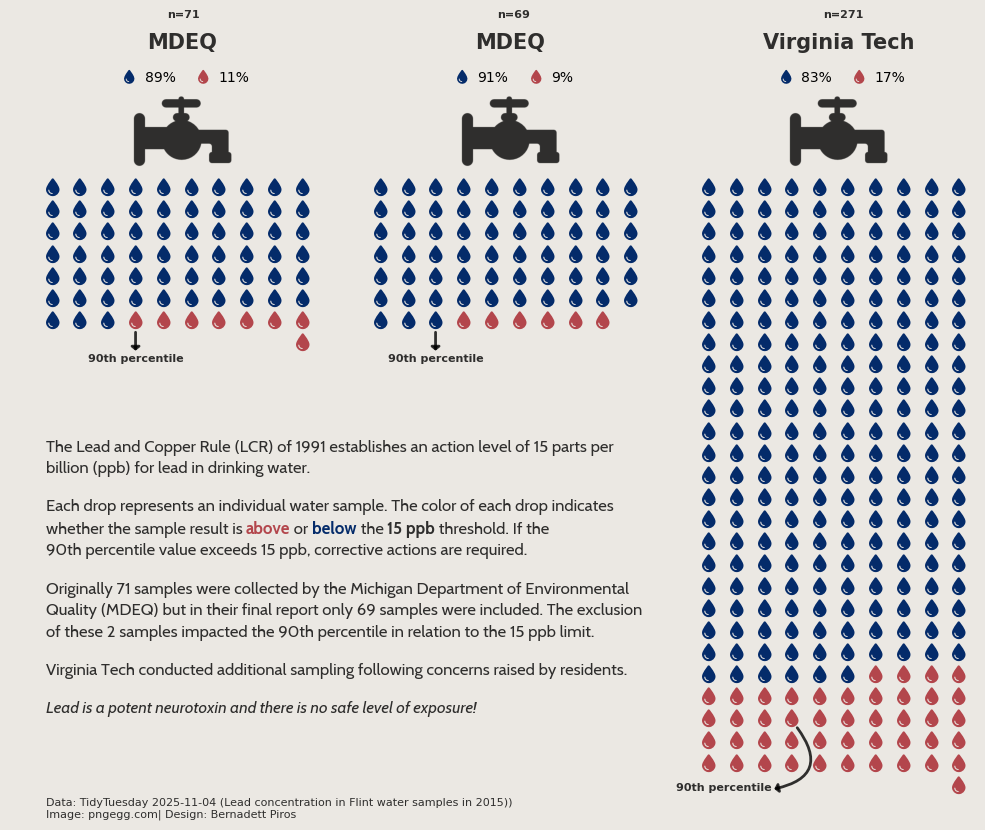

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 8))

# Iterate through unique values of sample name and axes to create waffles
for sn, ax in zip(agg_df["sample_name"].unique(), axs):
    # Create a subset for each sample name
    subset = agg_df[agg_df["sample_name"] == sn]
    # List the subset's count values 
    values = list(subset["count"].values)
    # Sort values in descending order
    values = sorted(values, reverse=True)
    # Define the height of waffle
    values.append(max_value - sum(values))  

    # Sort by count 
    subset = subset.sort_values("count", ascending=False)

    # Parameters for the legend labels
    counts = subset["count"].tolist()
    t = subset["threshold"].tolist()
    sum_count = sum(counts)

    # Labels for the legend
    labels = [f"{count / sum_count * 100:.0f}%" for t, count in zip(t, counts)]

    # Create the waffle
    Waffle.make_waffle(
        ax=ax,        
        columns=10,
        values=values,        
        icons="droplet",         
        block_arranging_style="snake",
        vertical=True,
        colors=colors,
        icon_legend=True,
        legend={
        "ncols": 2,
        "columnspacing": 1,
        "frameon": False,        
        "handletextpad": 0.1,
        "labels": labels,
        "loc": "upper center", 
        "bbox_to_anchor": (0.5, 1.22)
    }
    )

    # Flip the y axis for each subplot
    ax.invert_yaxis()    

# Background color
fig.set_facecolor("#EBE8E3")

######## Child axes

# Create 3 child axes for the image
child_axes = [ax.inset_axes([0.3, 0.75, 0.4, 0.7]) for ax in axs]

# Create a df with an column of img path repeated 
img_paths = ["faucet.png", "faucet.png", "faucet.png"]
df = pd.DataFrame({'img': img_paths})

# List of titles to add to each child axes
titles = ["MDEQ","MDEQ", "Virginia Tech"]

# Iterate through each child ax to add image and title
for child_ax, img_path, sn, title in zip(child_axes, df["img"], agg_df["sample_name"], titles):
    img = mpimg.imread(img_path)
    child_ax.imshow(img, alpha=0.8)       
    child_ax.set_title(title, y= 1.5, size=15, alpha=0.8, weight="bold", ha="center")
    child_ax.axis("off")  

######## Arrows and their text annotations

# 64th drop of mdeq1
fig_arrow(
   tail_position=(0.2, 0.71),
   head_position=(0.2, 0.68),
   **arrow_style,  
   fig=fig
)

fig.text(0.2, 0.67, "90th percentile", **annotation_style)

# 63rd drop of mdeq2
fig_arrow(
   tail_position=(0.45, 0.71),
   head_position=(0.45, 0.68),
   **arrow_style,
   fig=fig
)

fig.text(0.45, 0.67, "90th percentile", **annotation_style)

# 244th drop of vt
fig_arrow(
   tail_position=(0.75, 0.215),
   head_position=(0.73, 0.135),
   **arrow_style,
   radius=-0.8,
   fig=fig
)

fig.text(0.69, 0.134, "90th percentile", **annotation_style)

######## Texts and titles

# List of number of samples and their x coord
num_samples = ["n=71","n=69", "n=271"]
xs = [0.24, 0.515, 0.79]

# Iterate through the list of number of samples elements and add them as title above each child ax
for i, num_sample in enumerate(num_samples):
    fig.text(x=xs[i], y=1.1, s=num_sample, size=8, alpha=0.8, weight="bold", ha="center")
    
# Text to add 
txt = '''
        The Lead and Copper Rule (LCR) of 1991 establishes an action level of 15 parts per
        billion (ppb) for lead in drinking water.\n\n\n
        Each drop represents an individual water sample. The color of each drop indicates
        whether the sample result is <above> or <below> the <15 ppb> threshold. If the
        90th percentile value exceeds 15 ppb, corrective actions are required.\n\n\n
        Originally 71 samples were collected by the Michigan Department of Environmental
        Quality (MDEQ) but in their final report only 69 samples were included. The exclusion
        of these 2 samples impacted the 90th percentile in relation to the 15 ppb limit.\n\n\n
        Virginia Tech conducted additional sampling following concerns raised by residents.\n\n\n
        <Lead is a potent neurotoxin and there is no safe level of exposure!>
        '''
# Add text to the plot
fig_text(0.1, 0.58, s=txt, highlight_textprops=[
        {"color": "#B3464C", "alpha":1, "font": font2, "size": 12}, 
        {"color": "#042B6A", "alpha":1, "font": font2, "size": 12},
        {"font": font2, "size": 12},
        {"font": font3}
        ], size=12, alpha=0.8, font=font1, fig=fig)

# Add caption
fig.text(0.125, 0.1, "Data: TidyTuesday 2025-11-04 (Lead concentration in Flint water samples in 2015))\nImage: pngegg.com| Design: Bernadett Piros", size=8, alpha=0.8)
    
plt.show()

#fig.savefig("2025-11-04.png", bbox_inches='tight', pad_inches=0.2)